# To generate plots in Figure 2. 

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
from matplotlib import rc
from copy import deepcopy
from scipy.stats import norm
rc('text', usetex=False)
from cycler import cycler
import palettable
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
def convert_X_to_n(X):
    binvec = (1 - X)/2
    binvec= binvec.astype(int)
    n = np.sum((2**np.arange(len(X)))*binvec)
    return n

def generate_module_weights(n_m):
    return np.random.randn(2**n_m)

def get_module_output(weights,X, Ks):
    n = (1 - X)/2
    n = n.astype(int)
    coeffs = (-1)**np.matmul(Ks,n.T)
    
    return np.sum(coeffs*weights[:,None],axis=0)

def generate_modules(mus, M, maxn_m):
    p = len(mus)
    weights = []
    loci = []
    for m in range(M):
        n_m = 0
        selected_m = []
        while n_m > maxn_m or n_m < 1:
            locs = np.arange(p)
            selected_m = locs[np.random.uniform(size = p) < mus]
            n_m = len(selected_m)
        weights += [generate_module_weights(n_m)/np.sqrt(M)]
        loci += [selected_m]
    return weights, loci

def get_Ks_all(maxn_m):
    Ks_all = []
    for n_m in range(maxn_m+1):
        Ks = np.zeros((2**n_m, n_m),dtype = int)
        for i in range(Ks.shape[0]):
            Ks[i] = np.array([int(ii) for ii in bin(i)[2:].zfill(n_m)])
            
        Ks_all += [Ks]
    return Ks_all

def get_fitness(weights,loci,X, Ks_all):
    fitness = 0
    for m in range(M):
        n_m = len(loci[m])
        Ks = Ks_all[n_m]
            
        fitness += get_module_output(weights[m],X[:,loci[m]], Ks)
        
    return fitness

def compute_Vloci(weights,loci,Ks_all):
    Vloci = np.zeros(p)
    V = 0
    for m in range(len(weights)):
        n_m = len(loci[m])
        Ks = Ks_all[n_m]
        V += np.sum(weights[m][1:]**2)
        for i in range(n_m):
            filt = (Ks[:,i] == 1)
            Vloci[loci[m][i]] += np.sum(weights[m][np.arange(2**n_m)[filt]]**2)
    Vloci /= V
    
#Simulate an evolutionary trajectory

def evolve(genos, fitness, weights, loci, Ks_all):
    evolved = []
    Yevol = []
    Ys = get_fitness(weights,loci,genos, Ks_all)
    
    for ind in range(len(genos)):
        founder = genos[ind]
        nsteps = 40
        curr = deepcopy(founder)
        Ycurr = Ys[ind]

        times = []
        fixloci = []
        Ytraj = []
        ntime = 0
        vselected = []
        for i in range(nsteps):
            select = 0
            if Ycurr > fitness:
                evolved += [curr]
                Yevol += [deepcopy(Ycurr)]
                break
            while select == 0:
                ntime += 1
                temp = deepcopy(curr)
                locus = np.random.choice(p)
                temp[locus] *= -1
                Ynew = get_fitness(weights,loci,temp[None,:], Ks_all)[0]
                s = Ynew - Ycurr
                if np.random.uniform() < 2*s*1:
                    select = 1
                    Ycurr = Ynew
                    curr = deepcopy(temp)
                    fixloci += [locus]
                    times += [ntime]
                    Ytraj += [Ycurr]
                    vselected += [Vloci[locus]]
        #print("%d %.3f %.3f %d" %(ind, Ycurr, Ys[ind], i))
    return np.array(evolved), np.array(Yevol)

def evolve_gens(genos, generations, weights, loci, Ks_all):
    evolved = []
    Yevol = []
    Ys = get_fitness(weights,loci,genos, Ks_all)
    
    for ind in range(len(genos)):
        founder = genos[ind]
        nsteps = 40
        curr = deepcopy(founder)
        Ycurr = Ys[ind]

        times = []
        fixloci = []
        Ytraj = []
        ntime = 0
        vselected = []
        for i in range(nsteps):
            select = 0
            if ntime > generations:
                evolved += [curr]
                Yevol += [deepcopy(Ycurr)]
                break
            while select == 0:
                ntime += 1
                temp = deepcopy(curr)
                locus = np.random.choice(p)
                temp[locus] *= -1
                Ynew = get_fitness(weights,loci,temp[None,:], Ks_all)[0]
                s = Ynew - Ycurr
                if np.random.uniform() < 2*s*1:
                    select = 1
                    Ycurr = Ynew
                    curr = deepcopy(temp)
                    fixloci += [locus]
                    times += [ntime]
                    Ytraj += [Ycurr]
                    vselected += [Vloci[locus]]
        #print("%d %.3f %.3f %d" %(ind, Ycurr, Ys[ind], i))
    return np.array(evolved), np.array(Yevol)
    

In [20]:
#Parameters of CN model

mu = 0.02
p = int(8/mu)
mus = np.random.exponential(mu, size = p)
print(p)
M = 500
maxn_m = 14 #max epistatic order
weights,loci = generate_modules(mus, M, maxn_m)
Ks_all = get_Ks_all(maxn_m)

400


In [21]:
#Normalize variance 

n_ms = [len(loci[m]) for m in range(len(loci))]
print(np.mean(n_ms),np.std(n_ms),np.max(n_ms))

Vloci = np.zeros(p)
V = 0
for m in range(len(weights)):
    n_m = len(loci[m])
    Ks = Ks_all[n_m]
    V += np.sum(weights[m][1:]**2)
    for i in range(n_m):
        filt = (Ks[:,i] == 1)
        Vloci[loci[m][i]] += np.sum(weights[m][np.arange(2**n_m)[filt]]**2)
Vloci /= V

#Normalize weights
for m in range(len(weights)):
    weights[m] /= np.sqrt(V)

8.208 2.5792898247385847 14


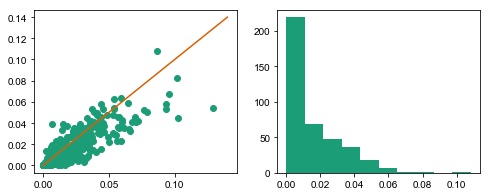

In [22]:
plt.close("all")
fig,axis = plt.subplots(1,2,figsize= (8,3))
axis[0].plot(mus/(1+mu),Vloci,'o')
axis[1].hist(Vloci)
xs = np.linspace(0,mu*7,10)
axis[0].plot(xs,xs)
plt.show()

In [17]:
#To show declining adaptability. 

n = 64
replicates = 12

bgs = 2*(np.random.randn(n,p) > 0) - 1

bgs_rep = np.repeat(bgs,replicates,axis=0)

Ys = get_fitness(weights,loci,bgs_rep, Ks_all)

print("1")
gens = 25
evolved1, Yevol1 = evolve_gens(bgs_rep, gens, weights, loci, Ks_all)
print("2")
gens = 25
evolved2, Yevol2 = evolve_gens(evolved1, gens, weights, loci, Ks_all)

1
2


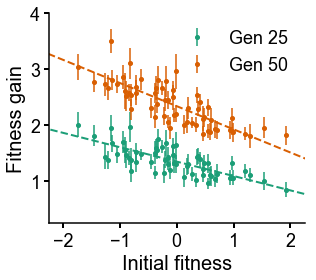

In [18]:
Yss = np.reshape(Ys, (n,replicates))
Yevol1s = np.reshape(Yevol1, (n,replicates))
Yevol2s = np.reshape(Yevol2, (n,replicates))

Ysmean = np.mean(Yss,axis=1)
Yevol1mean = np.mean(Yevol1s,axis=1)
Yevol1err = np.std(Yevol1s,axis=1)/np.sqrt(replicates)
Yevol2mean = np.mean(Yevol2s,axis=1)
Yevol2err = np.std(Yevol2s,axis=1)/np.sqrt(replicates)

plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_3.mpl_colors)))

plt.close("all")  
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

axis.errorbar(Ysmean,Yevol1mean - Ysmean, yerr = Yevol1err, fmt = 'o', ms = 4, label = "Gen 25")
axis.errorbar(Ysmean,Yevol2mean - Ysmean, yerr = Yevol2err, fmt = 'o', ms = 4, label = "Gen 50")

fit1 = np.polyfit(Ysmean, Yevol1mean - Ysmean,1)
fit2 = np.polyfit(Ysmean, Yevol2mean - Ysmean,1)

xs = np.linspace(-10,10,100)
axis.plot(xs, xs*fit1[0] + fit1[1], 'C0--' ,lw = 2)
axis.plot(xs, xs*fit2[0] + fit2[1], 'C1--' ,lw = 2)

axis.tick_params(labelsize = 18, width = 2, size = 5)

axis.legend(fontsize = 18, frameon = False )

axis.set_xlim(-2.25,2.25)
axis.set_ylim(0.25,4)

axis.set_xlabel(r"Initial fitness",fontsize = 20)
axis.set_ylabel("Fitness gain",fontsize = 20)

axis.set_yticks([1,2,3,4])
axis.set_xticks([-2,-1,0,1,2])
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/fitness_gain_adap_sim.pdf")

plt.show()

In [23]:
#For showing increasing costs epistasis

n = 64
bgs = 2*(np.random.randn(n,p) > 0) - 1
Ys = get_fitness(weights,loci,bgs, Ks_all)

evolveds = []
Yevols = []

Yfinals = [0.75,1.75,2.75,3.75,4.75]

for i in range(len(Yfinals)):
    print(i)
    evolved, Yevol = evolve(bgs, Yfinals[i], weights, loci, Ks_all)
    evolveds += [evolved]
    Yevols += [Yevol]

0
1
2
3
4


In [24]:
Nmuts = 30

mutloci = np.argsort(-Vloci)[::int(p/Nmuts)]

Nmuts = len(mutloci)
print(Nmuts)

Yevol_muts = np.zeros((len(Yfinals),Nmuts,n))

for i in range(Nmuts):
    if i%5 == 0:
        print(i)
    for j in range(len(Yfinals)):
        muts = deepcopy(evolveds[j])
        muts[:,mutloci[i]] *= -1 
        Yevol_muts[j,i] = get_fitness(weights,loci,muts, Ks_all)
    
Ymuts = np.zeros((Nmuts,len(bgs)))
for i in range(Nmuts):
    if i%5 == 0:
        print(i)
    muts = deepcopy(bgs)
    muts[:,mutloci[i]] *= -1 
    Ymuts[i] = get_fitness(weights,loci,muts, Ks_all)

31
0
5
10
15
20
25
30
0
5
10
15
20
25
30


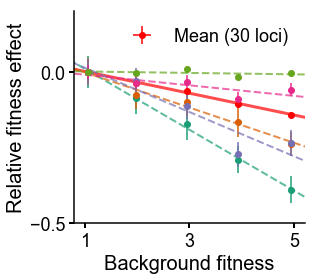

In [29]:
Yevols = np.array(Yevols)

xerrs = []
yerrs = []
xmeans = []
ymeans = []
for j in range(len(Yfinals)):
    xmean = np.mean(Yevols[j])
    ymean = np.mean(Yevol_muts[j] - Yevols[j])
    xerr= np.std(Yevols[j])/np.sqrt(len(Yevols[j]))
    yerr= np.std(Yevol_muts[j] - Yevols[j])/np.sqrt(Nmuts*n)
    xerrs += [xerr]
    yerrs += [yerr]
    xmeans += [xmean]
    ymeans += [ymean]
    

    
plt.rc('axes', prop_cycle=(cycler('color', palettable.cubehelix.cubehelix3_16.mpl_colors)))
plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_5.mpl_colors)))

    
plt.close("all")  
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

fac = 1

axis.errorbar(xmeans, ymeans - fac*ymeans[0], xerr = xerrs, yerr = yerrs, fmt = 'ro', label = "Mean (30 loci)")
fits = np.polyfit(xmeans,ymeans- fac*ymeans[0],1)
x = np.linspace(0,6,100)
axis.plot(x,x*fits[0] + fits[1],'r-',lw = 3,alpha = 0.7)

inds = [2,4,6,15,25]
for ii,ind in enumerate(inds):
    xerrs = []
    yerrs = []
    xmeans = []
    ymeans = []
    for j in range(len(Yfinals)):
        xmean = np.mean(Yevols[j])
        ymean = np.mean(Yevol_muts[j,ind] - Yevols[j])
        xerr= np.std(Yevols[j])/np.sqrt(len(Yevols[j]))
        yerr= np.std(Yevol_muts[j,ind] - Yevols[j])/np.sqrt(n)
        xerrs += [xerr]
        yerrs += [yerr]
        xmeans += [xmean]
        ymeans += [ymean]
    color = 1*ii
    axis.errorbar(xmeans, ymeans- fac*ymeans[0], xerr = xerrs, yerr = yerrs, fmt = 'C%do'%(color))
    fits = np.polyfit(xmeans,ymeans- fac*ymeans[0],1)
    x = np.linspace(0,6,100)
    axis.plot(x,x*fits[0] + fits[1],'C%d--'%(color),lw = 2,alpha = 0.7)


axis.set_xlim(0.8,5.2)
axis.set_ylim(-0.5,0.2)
axis.set_xlabel(r"Background fitness",fontsize = 20)
axis.set_ylabel("Relative fitness effect",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
leg = axis.legend(fontsize = 18, frameon = False)

axis.set_yticks([-0.5,0])
axis.set_xticks([1,3,5])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/simulation_dfe_mean_samples.pdf")
plt.show()

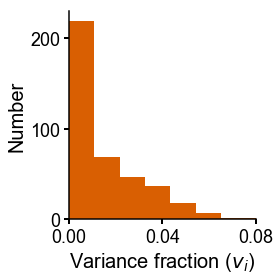

In [32]:
plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (4,4))

axis.hist(Vloci, color = 'C9')

axis.set_xlim(0.0,0.08)

axis.set_xlabel(r"Variance fraction ($v_i$)",fontsize = 20)
axis.set_ylabel("Number",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)

axis.set_yticks([0,100,200])
axis.set_xticks([0,0.04,0.08])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dvf_sim.pdf")
plt.show()

In [33]:
#Double mutants
N2muts = 30

n = len(bgs)

mutloci = np.argsort(-Vloci)[::int(p/N2muts)]
N2muts = len(mutloci)
print(N2muts)

Yevol_2muts_1 = np.zeros((len(Yfinals),N2muts,n))
Yevol_2muts_2 = np.zeros((len(Yfinals),N2muts, N2muts,n))


for i in range(N2muts):
    if i%5 == 0:
        print(i)
    for j in range(len(Yfinals)):
        muts = deepcopy(evolveds[j])
        muts[:,mutloci[i]] *= -1 
        Yevol_2muts_1[j,i] = get_fitness(weights,loci,muts, Ks_all)
        
for i in range(N2muts):
    if i%5 == 0:
        print(i)
    for i2 in range(i+1,N2muts):
        for j in range(len(Yfinals)):
            muts = deepcopy(evolveds[j])
            muts[:,mutloci[i]] *= -1
            muts[:,mutloci[i2]] *= -1
            Yevol_2muts_2[j,i,i2] =  get_fitness(weights,loci,muts, Ks_all)
            Yevol_2muts_2[j,i2,i] = Yevol_2muts_2[j,i,i2]
            
Y2muts_1 = np.zeros((N2muts,n))
Y2muts_2 = np.zeros((N2muts, N2muts,n)) 
    

for i in range(N2muts):
    muts = deepcopy(bgs)
    muts[:,mutloci[i]] *= -1
    Y2muts_1[i] = get_fitness(weights,loci,muts, Ks_all)

for i in range(N2muts):
    if i%5 == 0:
        print(i)
    for j in range(i+1,N2muts):
        muts = deepcopy(bgs)
        muts[:,mutloci[i]] *= -1
        muts[:,mutloci[j]] *= -1
        Y2muts_2[i,j] =  get_fitness(weights,loci,muts, Ks_all)
        Y2muts_2[j,i] = Y2muts_2[i,j]

31
0
5
10
15
20
25
30
0
5
10
15
20
25
30
0
5
10
15
20
25
30


-0.03606266387905775
-0.07103978555665666


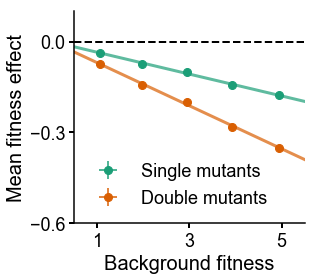

In [81]:

    

plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_3.mpl_colors)))

    
plt.close("all")  
fig,axis = plt.subplots(1,1,figsize = (4.5,4))


xerrs = []
yerrs = []
xmeans = []
ymeans = []
for j in range(len(Yfinals)):
    xmean = np.mean(Yevols[j])
    ymean = np.mean(Yevol_2muts_1[j] - Yevols[j,None,None])
    xerr= np.std(Yevols[j])/np.sqrt(len(Yevols[j]))
    yerr= np.std(Yevol_2muts_1[j] - Yevols[j])/np.sqrt(N2muts*n)
    xerrs += [xerr]
    yerrs += [yerr]
    xmeans += [xmean]
    ymeans += [ymean]
    
    

axis.errorbar(xmeans, ymeans , xerr = xerrs, yerr = yerrs, fmt = 'C0o', label = "Single mutants", ms = 8)
fits = np.polyfit(xmeans,ymeans ,1)
x = np.linspace(0.5,5.5,100)
axis.plot(x,x*fits[0] + fits[1],'C0-',lw = 3,alpha = 0.7)
print(fits[0])
xerrs = []
yerrs = []
xmeans = []
ymeans = []
for j in range(len(Yfinals)):
    xmean = np.mean(Yevols[j])
    Y2_m = np.mean(Yevol_2muts_2[j],axis=-1)
    Yevols_m = np.mean(Yevols[j],axis=-1)
    nz = np.abs(Y2_m) > 1e-5 #remove diagonal elements which are all zeros
    ymean = np.mean(Y2_m[nz]) - np.mean(Yevols[j])
    xerr= np.std(Yevols[j])/np.sqrt(len(Yevols[j]))
    yerr= np.std(Yevol_2muts_2[j] - Yevols[j])/np.sqrt(N2muts*N2muts*n)
    xerrs += [xerr]
    yerrs += [yerr]
    xmeans += [xmean]
    ymeans += [ymean]
    
    
axis.errorbar(xmeans, ymeans, xerr = xerrs, yerr = yerrs, fmt = 'C1o', label = "Double mutants", ms = 8)
fits = np.polyfit(xmeans,ymeans,1)
x = np.linspace(0.5,5.5,100)
axis.plot(x,x*fits[0] + fits[1],'C1-',lw = 3,alpha = 0.7)

print(fits[0])
axis.plot(x,0*x, 'k--', lw = 2,alpha = 1)

axis.set_xlim(0.5,5.5)
axis.set_ylim(-0.6,0.1)
axis.set_xlabel(r"Background fitness",fontsize = 20)
axis.set_ylabel("Mean fitness effect",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
leg = axis.legend(fontsize = 18, frameon = False, loc = 3)

axis.set_yticks([-0.6,-0.3,0])
axis.set_xticks([1,3,5])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfemean_bgrnd_fitness.pdf")
plt.show()

In [58]:
Vloci[mutloci]

array([1.08433547e-01, 5.31090723e-02, 4.49224387e-02, 3.93592972e-02,
       3.55668817e-02, 3.21791500e-02, 2.92119648e-02, 2.61176751e-02,
       2.30727544e-02, 1.92634423e-02, 1.74137371e-02, 1.51474816e-02,
       1.36138658e-02, 1.22180351e-02, 1.05621366e-02, 9.26455184e-03,
       8.01477890e-03, 7.25185349e-03, 6.11843801e-03, 5.10149523e-03,
       3.47903018e-03, 2.80463176e-03, 2.16085412e-03, 1.70279266e-03,
       1.18042400e-03, 7.75838945e-04, 3.19310605e-04, 1.05530907e-04,
       2.61233407e-06, 0.00000000e+00, 0.00000000e+00])

In [85]:
#To plot the slope vs. res. var prediction

n = 256

bgs = 2*(np.random.randn(n,p) > 0) - 1
Y3 = get_fitness(weights,loci,bgs, Ks_all)

N3muts = 15
mutloci = np.argsort(-Vloci)[:N3muts]
#mutloci = np.argsort(-Vloci)[::int(p/N3muts)]
N3muts = len(mutloci)
print(N3muts)

Y3muts = np.zeros((N3muts,n))
Y32muts = np.zeros((N3muts, N3muts,n)) 
    
for i in range(N3muts):
    muts = deepcopy(bgs)
    muts[:,mutloci[i]] *= -1
    Y3muts[i] = get_fitness(weights,loci,muts, Ks_all)

for i in range(N3muts):
    if i%5 == 0:
        print(i)
    for j in range(i+1,N3muts):
        muts = deepcopy(bgs)
        muts[:,mutloci[i]] *= -1
        muts[:,mutloci[j]] *= -1
        Y32muts[i,j] =  get_fitness(weights,loci,muts, Ks_all)
        Y32muts[j,i] = Y32muts[i,j]


15
0
5
10


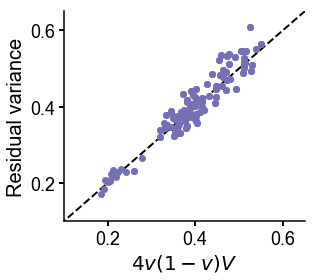

In [86]:
plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)))

#Plot the residual variance vs 4v(1-v)V for double mutants
vs2 = np.zeros((N3muts,N3muts))
resvars2 = np.zeros((N3muts,N3muts))
intercepts2 = np.zeros((N3muts,N3muts))

vs = np.zeros(N3muts)
resvars = np.zeros(N3muts)
intercepts = np.zeros(N3muts)
    
    
for i in range(N3muts):
    
    Ybase = Y3.flatten()
    Ynew = Y3muts[i]
    
    mean1 = np.mean(Ybase)
    mean2 = np.mean(Ynew)
    std1 = np.std(Ybase)
    std2 = np.std(Ynew)
    corr= np.mean((Ybase - mean1)*(Ynew - mean2))/(std1*std2)
    resvars[i] = np.std(Ynew - corr*Ybase)**2
    vs[i] = (1-corr)/2.0
    #print(corr, resvars[i])
    for j in range(i+1,N3muts):
        Ynew2 =  Y32muts[i,j].flatten()
        mean1 = np.mean(Ybase)
        mean2 = np.mean(Ynew2)
        std1 = np.std(Ybase)
        std2 = np.std(Ynew2)
        corr= np.mean((Ybase - mean1)*(Ynew2 - mean2))/(std1*std2)
        resvars2[i,j] = np.std(Ynew2 - corr*Ybase)**2
        resvars2[j,i] = resvars2[i,j]
        vs2[i,j] = (1-corr)/2.0
        vs2[j,i] = (1-corr)/2.0
    
    
totalvar = np.std(Ybase)**2    

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

fits = np.polyfit((vs2*(1-vs2)).flatten(),resvars2.flatten(),1)
xs = np.linspace(0.0,0.7,100)
#axis.plot(xs,xs*fits[0] + fits[1],'C2-',lw = 2)
axis.plot(xs,xs,'k--',lw = 2)

axis.plot(4*vs*(1-vs)*totalvar,resvars,'C2o', ms = 5, mew = 2)
axis.plot(4*vs2*(1-vs2)*totalvar,resvars2,'C2o', ms = 5, mew = 2,alpha = 1)

axis.set_xlim(0.1,0.65)
axis.set_ylim(0.1,0.65)
axis.set_xlabel(r"$4v(1-v)V$",fontsize = 20)
axis.set_ylabel("Residual variance",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
#axis.set_xticks([0.2,0.5])
#axis.set_yticks([0.2,0.5])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/allmut_resvar_slope.pdf")
plt.show()
    


(15, 15)


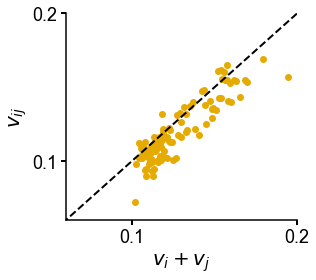

In [87]:
# Plot the variance fraction of double mutants vs sum of single mutants

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
for i in range(N3muts):
    for j in range(i+1,N3muts):
        axis.plot(vs[i] + vs[j], vs2[i,j],'C5o', ms = 5, mew = 2)
  
print(vs2.shape)
xs =np.linspace(0,0.5)
axis.plot(xs,xs,'k--',lw = 2)
axis.set_xlim(0.06,0.2)
axis.set_ylim(0.06,0.2)
axis.set_xlabel(r"$v_i + v_j$",fontsize = 20)
axis.set_ylabel(r"$v_{ij}$",fontsize = 20)

axis.tick_params(labelsize = 18, width = 2, size = 5)
axis.set_xticks([0.1,0.2])
axis.set_yticks([0.1,0.2])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/doublemut_slopes.pdf")
plt.show()
    



In [84]:
#Plot DFE vs background fitness for individual loci
i = 3
j = 19
#print(Vloci[mutloci[i]],Vloci[mutloci[j]])
plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)))
#Use filters

ndiv = 7
filters = np.zeros(ndiv)
meanx = np.mean(Ys)
stdx = np.std(Ys)
minx = -0.8
maxx = 1.2
for k in range(1,ndiv+1):
    filters[k-1] = norm.ppf(k/(ndiv+1))*(maxx-minx) + minx

filters = np.arange(-1.2,1.3,0.35)
    
Ysfiltered = []
FE2filtered = []
FE2filtered_std = []
FE1ifiltered = []
FE1ifiltered_std = []
FE1jfiltered = []
FE1jfiltered_std = []

FE2 = Y2muts[i,j] - Ys
FE1i = Ymuts[i] - Ys
FE1j = Ymuts[j] - Ys

for k in range(len(filters)-1):
    filt = (Ys > filters[k])*(Ys < filters[k+1])
    Ysfiltered += [np.mean(Ys[filt])]
    FE2filtered += [np.mean(FE2[filt])]
    FE2filtered_std += [np.std(FE2[filt])/np.sqrt(len(FE2[filt]))]
    FE1ifiltered += [np.mean(FE1i[filt])]
    FE1ifiltered_std += [np.std(FE1i[filt])/np.sqrt(len(FE1i[filt]))]
    FE1jfiltered += [np.mean(FE1j[filt])]
    FE1jfiltered_std += [np.std(FE1j[filt])/np.sqrt(len(FE1j[filt]))]
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

mean1 = np.mean(Ys)
mean2 = np.mean(Ymuts[i])
std1 = np.std(Ys)
std2 = np.std(Ymuts[i])
corr= np.mean((Ys - mean1)*(Ymuts[i] - mean2))/(std1*std2)


axis.errorbar(Ysfiltered,FE1ifiltered, yerr = FE1ifiltered_std, c = 'C0', capsize = 2, fmt = 'o', label = "Single mutants",  ms = 8, mew = 2 )

axis.plot(Ys,Ymuts[i] - Ys,'C0o',alpha=1)
# axis.plot(Ys,Ymuts[j] - Ys,'C2o',alpha=1)
# axis.plot(Ys,Y2muts[i,j] - Ys,'C1o',alpha=1)
xs =np.linspace(-4,4)
axis.plot(xs,xs*0,'k--',lw = 2)
axis.plot(xs, -xs*corr, 'C0--', lw = 3)

axis.set_xlim(-1.5,1.5)
axis.set_ylim(-1.5,1.5)
axis.set_xlabel(r"Background fitness ($y-\bar{y}$)",fontsize = 22)
axis.set_ylabel("Fitness effect ($s_i$)",fontsize = 22)
axis.tick_params(labelsize = 20, width = 2, size = 5)
#leg = axis.legend(fontsize = 18, frameon = False)

axis.set_yticks([-2,0,2])
axis.set_xticks([-2,0,2])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()

fits1 = np.polyfit(Ys,Ymuts[i] - Ys,1)
fits2 = np.polyfit(Ys,Ymuts[j] - Ys,1)
fits12 = np.polyfit(Ys,Y2muts[i,j] - Ys,1)
# print(-fits1[0]/2, Vloci[mutloci[i]])
# print(-fits2[0]/2, Vloci[mutloci[j]])
# print(-fits12[0]/2, (Vloci[mutloci[i]]+Vloci[mutloci[j]]))
print((1-corr)/2, Vloci[mutloci[i]])
fig.savefig("./RandomQTL_Plots/fe_bgrnd_fitness_example.pdf")
plt.show()

NameError: name 'Y2muts' is not defined

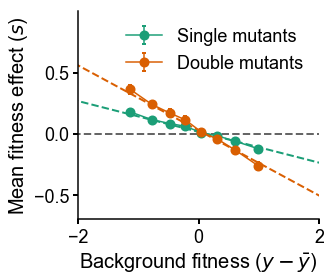

In [29]:
#Plot DFE mean vs background fitness for double mutants

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.7,4))

#Use filters

ndiv = 9
filters = np.zeros(ndiv)
meanx = np.mean(Ys)
stdx = np.std(Ys)
for i in range(1,ndiv+1):
    filters[i-1] = norm.ppf(i/(ndiv+1))*stdx + meanx
    
#filters = np.arange(-1.5,1.7,0.5)

Ysfiltered = []
FE2filtered = []
FE2filtered_std = []
FE1filtered = []
FE1filtered_std = []

FE2 = np.mean(Y2muts,axis=(0,1)) - Ys
FE1 = np.mean(Ymuts,axis=(0)) - Ys
for i in range(len(filters)-1):
    filt = (Ys > filters[i])*(Ys < filters[i+1])
    Ysfiltered += [np.mean(Ys[filt])]
    FE2filtered += [np.mean(FE2[filt])]
    FE2filtered_std += [np.std(FE2[filt])/np.sqrt(len(FE2[filt]))]
    FE1filtered += [np.mean(FE1[filt])]
    FE1filtered_std += [np.std(FE1[filt])/np.sqrt(len(FE1[filt]))]

axis.errorbar(Ysfiltered,FE1filtered, yerr = FE1filtered_std, c = 'C0', capsize = 2, marker = 'o', label = "Single mutants",  ms = 8, mew = 2)
axis.errorbar(Ysfiltered,FE2filtered, yerr = FE2filtered_std, c = 'C1', capsize = 2, marker = 'o', label = "Double mutants", ms = 8, mew = 2)

#axis.plot(Ys,np.mean(Y2muts,axis=(0,1)) - Ys,'C1o', label = "Double mutants", fillstyle = 'none', ms = 8, mew = 1.5)
#axis.plot(Ys,np.mean(Ymuts,axis=(0)) - Ys,'C0o', label = "Single mutants", fillstyle = 'none', ms = 8, mew = 1.5)

xs =np.linspace(-7,7)
axis.plot(xs,xs*0,'k--',lw = 2, alpha = 0.6)

fits = np.polyfit(Ys,np.mean(Y2muts,axis=(0,1)) - Ys,1)
axis.plot(xs,xs*fits[0] + fits[1], 'C1--', lw = 2)

fits = np.polyfit(Ys,np.mean(Ymuts,axis=0) - Ys,1)
axis.plot(xs,xs*fits[0] + fits[1], 'C0--', lw = 2)

axis.set_xlim(-2,2)
axis.set_ylim(-0.7,1)
axis.set_xlabel(r"Background fitness ($y-\bar{y}$)",fontsize = 20)
axis.set_ylabel("Mean fitness effect ($s$)",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
leg = axis.legend(fontsize = 18, frameon = False)

axis.set_yticks([-0.5,0,0.5])
axis.set_xticks([-2,0,2])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
#fig.savefig("./RandomQTL_Plots/dfemean_bgrnd_fitness.pdf")
plt.show()